モジュールのインポート

In [1]:
import numpy as np
from two_layer_net import TwoLayerNet
import matplotlib.pyplot as plt

MNISTデータセットを取ってくるための準備

In [2]:
# coding: utf-8
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np
from pathlib import Path


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.dirname(Path().resolve())
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name

    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    headers = {"User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:47.0) Gecko/20100101 Firefox/47.0"}
    request = urllib.request.Request(url_base+file_name, headers=headers)
    response = urllib.request.urlopen(request).read()
    with open(file_path, mode='wb') as f:
        f.write(response)
    print("Done")

def download_mnist():
    for v in key_file.values():
       _download(v)

def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")

    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")

    return data

def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])

    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1

    return T


def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNISTデータセットの読み込み
    Parameters
    ----------
    normalize : 画像のピクセル値を0.0~1.0に正規化する
    one_hot_label :
        one_hot_labelがTrueの場合、ラベルはone-hot配列として返す
        one-hot配列とは、たとえば[0,0,1,0,0,0,0,0,0,0]のような配列
    flatten : 画像を一次元配列に平にするかどうか
    Returns
    -------
    (訓練画像, 訓練ラベル), (テスト画像, テストラベル)
    """
    if not os.path.exists(save_file):
        init_mnist()

    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)

    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0

    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])


In [3]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
#損失関数を記録する配列
train_loss_list = []

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

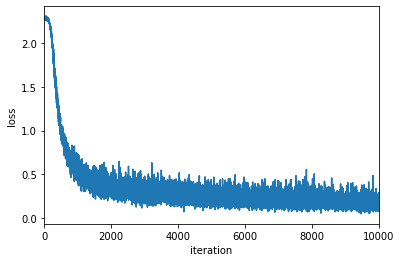

In [4]:
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train acc')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.xlim(0, 10000)
plt.show()

In [14]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.10218333333333333, 0.101
train acc, test acc | 0.7769166666666667, 0.7856
train acc, test acc | 0.8788166666666667, 0.882
train acc, test acc | 0.8996333333333333, 0.9002
train acc, test acc | 0.9088333333333334, 0.9094
train acc, test acc | 0.9141333333333334, 0.9169
train acc, test acc | 0.9207166666666666, 0.9227
train acc, test acc | 0.9241833333333334, 0.9258
train acc, test acc | 0.9277, 0.9278
train acc, test acc | 0.9309333333333333, 0.9317
train acc, test acc | 0.935, 0.9346
train acc, test acc | 0.9367833333333333, 0.9366
train acc, test acc | 0.93985, 0.9394
train acc, test acc | 0.9416833333333333, 0.9411
train acc, test acc | 0.9431, 0.9413
train acc, test acc | 0.94525, 0.9424
train acc, test acc | 0.9470833333333334, 0.9455


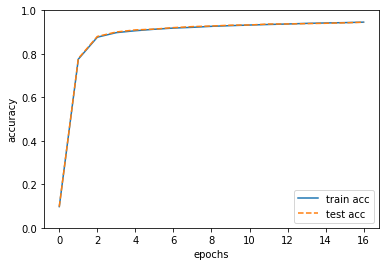

In [6]:
# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

パラメータを変えて実行してみよう

In [15]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.09035, 0.0892


c:\Users\Kawai\OneDrive - 国立大学法人東海国立大学機構\zero-one-seminar\deep_larning\2022-f-DeepLearning-08\ミニバッチ学習\two_layer_net.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


KeyboardInterrupt: 